In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class VGG19(nn.Sequential):
    def __init__(self):
        super().__init__(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 1000)
            )

In [26]:
# pretrained models
model = models.get_model('vgg19', weights='VGG19_Weights.DEFAULT').to(device)
# model = models.get_model('resnet50', weights='ResNet50_Weights.DEFAULT').to(device)

# our model
# model = VGG19()
# model.load_state_dict(torch.load('trained.pth'))
# model = model.to(device)

In [13]:
content_image = Image.open("cat.jpg")
style_image = Image.open("van-gogh-la-nuit-etoilee-1.jpg")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
tensor_to_img = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: x.clamp(0, 255)),
    transforms.ToPILImage(),
])

In [27]:
# define layers used for style transfer
# pretrained vgg19
content_layer = model.features[22]  # conv4_2
style_layers = [model.features[1],  # conv1_1
                model.features[6],  # conv2_1
                model.features[11],  # conv3_1
                model.features[20],  # conv4_1
                model.features[29]]  # conv5_1

In [21]:
# resnet50
content_layer = model.layer3[5].relu
style_layers = [model.layer1[2].relu,
                model.layer2[3].relu,
                model.layer3[5].relu,
                model.layer4[2].relu]

In [14]:
# our model
content_layer = model[22]  # conv4_2
style_layers = [model[1],  # conv1_1
                model[6],  # conv2_1
                model[11],  # conv3_1
                model[20],  # conv4_1
                model[29]]  # conv5_1

In [28]:

# disable gradient computation for model parameters
model.requires_grad_(False)

# add hooks to save the activations of intermediate layers
# on call to forward()
content_activation = [None]
def content_hook(model, input, output):
    content_activation[0] = output
content_layer.register_forward_hook(content_hook)

style_activation = [None] * len(style_layers)
def get_style_hook(i):  # hook for i-th style layer
    def style_hook(model, input, output):
        style_activation[i] = output
    return style_hook
for i, layer in enumerate(style_layers):
    layer.register_forward_hook(get_style_hook(i))

In [29]:
content_weight = 1e-2
style_weight = 1
style_transfer_learning_rate = .02
num_steps = 5000

def style_transfer_loss(x, content_target, style_target):
    total_squared_error = nn.MSELoss(reduction='sum')
    model(x.unsqueeze(0))

    content_loss = total_squared_error(content_activation[0].squeeze(0), content_target)

    style_loss = 0
    for activation, target in zip(style_activation, style_target):
        activation = activation.squeeze(0)
        style_loss += total_squared_error(gram_matrix(activation), target)
    style_loss /= len(style_layers)
    return content_weight * content_loss + style_weight * style_loss, content_loss, style_loss

def gram_matrix(activation):
    shape = activation.shape
    a = activation.view(shape[0], shape[1] * shape[2])  # flatten pixels to one dimension
    return a @ a.T / a.size()[0]  # (scaled) scalar product of the pixel values for each pair of channels

def style_transfer(content_image, style_image):
    content_tensor = preprocess(content_image)
    style_tensor = preprocess(style_image)
    batch = torch.stack((content_tensor, style_tensor))
    batch = batch.to(device)
    model(batch)
    content_target = content_activation[0][0]
    style_target = [gram_matrix(activation[1]) for activation in style_activation]

    # initialize using the content image to save time
    generated = content_tensor.detach().clone().to(device).requires_grad_(True)
    #generated = torch.randn(content_tensor.shape, requires_grad=True, device=device)

    optimizer = torch.optim.Adam([generated], lr=style_transfer_learning_rate)

    losses = []
    content_losses = []
    style_losses = []
    for i in tqdm(range(num_steps)):
        loss, content_loss, style_loss = style_transfer_loss(generated, content_target, style_target)
        losses.append(loss.detach().cpu())
        content_losses.append(content_loss.detach().cpu())
        style_losses.append(style_loss.detach().cpu())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return generated.detach().cpu(), losses, content_losses, style_losses

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:39<00:00, 50.38it/s]


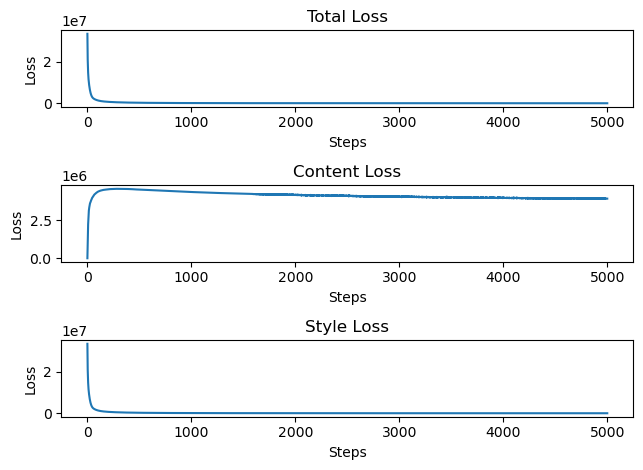

In [30]:
generated, losses, content_losses, style_losses = style_transfer(content_image, style_image)
fig, axs = plt.subplots(3, 1)

axs[0].set_title("Total Loss")
axs[0].plot(losses)
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")

axs[1].set_title("Content Loss")
axs[1].plot(content_losses)
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Loss")

axs[2].set_title("Style Loss")
axs[2].plot(style_losses)
axs[2].set_xlabel("Steps")
axs[2].set_ylabel("Loss")

plt.tight_layout()
plt.show()

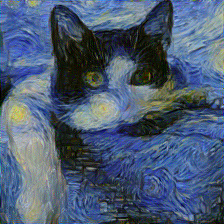

In [31]:
image = tensor_to_img(generated)
image